# Convolutional Neural Network Part 2
In this notebook, we are going to implement a Convolutional Neural Network with the hyperparameters obtained in the first part. This time, we will use a bigger part of the dataset. The steps are almost identical

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc='progress-bar')
from sklearn import utils
from sklearn.model_selection import train_test_split 
from keras.preprocessing.sequence import pad_sequences
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers
import datetime

print(datetime.datetime.now())

Using TensorFlow backend.


2019-11-21 12:19:46.748878


We load the dataset and keep the columns that we are going to use

In [2]:
%%time
df = pd.read_json('IMDB_reviews.json', lines=True)
df = df[['is_spoiler', 'review_text']]
df.is_spoiler = df.is_spoiler.astype(int)
df.head()

Wall time: 15.5 s


,is_spoiler,review_text
0,1,"In its Oscar year, Shawshank Redemption (writt..."
1,1,The Shawshank Redemption is without a doubt on...
2,1,I believe that this film is the best story eve...
3,1,"**Yes, there are SPOILERS here**This film has ..."
4,1,At the heart of this extraordinary movie is a ...


## 1.- Balancing and Preprocessing
### 1.1.- Balancing
Since the data is not balanced (see previous notebooks), we use undersampling to obtain a balanced subset.<br> This time, the balanced subset contains 150.000 reviews

Random Undersampling


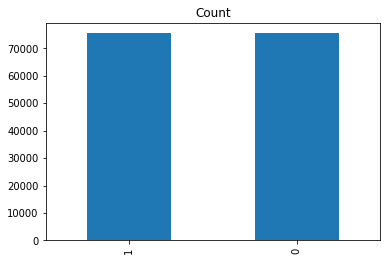

1    75462
0    75462
Name: is_spoiler, dtype: int64
Wall time: 471 ms


In [3]:
%%time
# Class count
count_not_spoiler, count_spoiler = df.is_spoiler.value_counts()

# Divide by class
df_spoiler = df[ df['is_spoiler'] == 1 ]
df_not_spoiler = df[ df['is_spoiler'] == 0 ]

# Random undersampling
# We reduce the number of not spoiler to the number of spoiler
# We use floor division (//)
df_not_spoiler_under = df_not_spoiler.sample(int(count_spoiler//2))
df_spoiler_under = df_spoiler.sample(int(count_spoiler//2))
df_balanced = pd.concat([df_not_spoiler_under, df_spoiler_under], axis=0)

# We randomize the order of the rows
df_balanced = df_balanced.sample(frac=1)

# The resulting dataset is balanced (100.616 reviews with spoilers and 100.616 without spoilers)
print('Random Undersampling')
df_balanced.is_spoiler.value_counts().plot(kind='bar', title='Count')
plt.show()
print(df_balanced.is_spoiler.value_counts())

We split the balanced dataset in training and test, The function returns a Numpy array

In [4]:
df_balanced.columns

Index(['is_spoiler', 'review_text'], dtype='object')

In [5]:
reviews = df_balanced['review_text'].values
y = df_balanced['is_spoiler'].values

# Splitting in training and test set
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews, y, test_size=0.3, random_state=1000)

### 1.2- Preprocessing
We define the tokenize() function created in previous notebooks with the only difference that this time it returns a simple string instead of a list of strings. <br>
The name of the function has been changed to preprocess to avoid confusions with the keras function that has the same name

In [6]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    precision = history.history['precision_m']
    val_precision = history.history['val_precision_m']
    
    recall = history.history['recall_m']
    val_recall = history.history['val_recall_m']
    
    f1 = history.history['f1_m']
    val_f1 = history.history['val_f1_m']
    
    x = range(1, len(acc) + 1)
    
    
    plt.figure(figsize=(24, 10))
    
    plt.subplot(2, 2, 1)
    plt.ylim(0., 1.)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(x, precision, 'b', label='Training precision')
    plt.plot(x, val_precision, 'r', label='Validation precision')
    plt.ylim(0., 1.)
    plt.title('Training and validation precision')
    plt.legend()
    
    plt.subplot(2, 2, 3)
    plt.plot(x, recall, 'b', label='Training recall')
    plt.plot(x, val_recall, 'r', label='Validation recall')
    plt.ylim(0., 1.)
    plt.title('Training and validation recall')
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.plot(x, f1, 'b', label='Training f1-score')
    plt.plot(x, val_f1, 'r', label='Validation f1-score')
    plt.ylim(0., 1.)
    plt.title('Training and validation f1-score')
    plt.legend()
    plt.show()

In [7]:
# We create a map that takes the outputs of pos-tagging and convert them into the inputs of lemmatization
# We use name as the default value
pos_map = {'CC': 'n','CD': 'n','DT': 'n','EX': 'n','FW': 'n','IN': 'n','JJ': 'a','JJR': 'a',
'JJS': 'a','LS': 'n','MD': 'v','NN': 'n','NNS': 'n','NNP': 'n','NNPS': 'n','PDT': 'n',
'POS': 'n','PRP': 'n','PRP$': 'r','RB': 'r','RBR': 'r','RBS': 'r','RP': 'n','TO': 'n',
'UH': 'n','VB': 'v','VBD': 'v','VBG': 'v','VBN': 'v','VBP': 'v','VBZ': 'v','WDT': 'n', 'WP': 'n','WP$': 'n','WRB': 'r'}

from nltk.corpus import stopwords

# We define our stop words list
stop_words = set(stopwords.words('english'))
len(stop_words)

179

In [8]:
import nltk
from bs4 import BeautifulSoup
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

# We initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess(example_sent):
    # example_sent = "Hi, it's me"
    # Since all the stopwords are in lower case, we have to convert the string to lowercase first
    example_sent = example_sent.lower()

    # This was a simple tokenizer that kept the punctuation symbols
    # word_tokens = word_tokenize(example_sent)
    
    # Japanese words are kept as a single word, so we can remove them easily, but urls, emails and html tags are splitted, so we
    # have to remove them before tokenizing
    
    # Removing url, emails and html tags
    # HTML TAGS
    example_sent = BeautifulSoup(example_sent, 'lxml').text

    # EMAIL ADDRESSES
    example_sent = re.sub(r'[\w\.-]+@[\w\.-]+', ' ', example_sent)

    # URLs
    example_sent = re.sub(r'http\S+', '', example_sent)

    # Removing punctuation symbol
    tokenizer = RegexpTokenizer(r'\w+')
    word_tokens = tokenizer.tokenize(example_sent)
    # Now we have obtained the tokenized words without punctuation symbols and with stopwords

    # POS Tagging the data (the stopwords improve the accuracy of the pos tagging, so we'll remove them later)
    # This method returns a list of tuples: (word, classification)
    tags = nltk.pos_tag(word_tokens)

    # We lemmatize all the words in the text by their category
    for i, word in enumerate(word_tokens):
        # Returns the lemmatized word given its category (if the key is not part of the map, the word is considered a noun)
        word_tokens[i] = lemmatizer.lemmatize(word, pos=pos_map.get(tags[i][1] , 'n'))

    # Removing stop words
    filtered_sentence = [w for w in word_tokens if not w in stop_words]

    # In html:  <br>  -->  br
    # In email:  jua@gmail.com  --> jua, gmail, com
    # In url: https://www.youtube.com  --> http, www, youtube, com
    
    filtered_sentence_string = ' '.join(filtered_sentence)
    return filtered_sentence_string

In [9]:
# Testing the tokenizer
test = "<HTML>This <p>is.a</p> ! jua@email.com sentences, showing off the <br> stop words filtration. http://www.youtube.com"
preprocess(test)

'sentence show stop word filtration'

In [10]:
reviews_train[0]

'My only comment is regarding the voice used by Mr. Day-Lewis in his portrayal of Abraham Lincoln. I have read about the decision to use a higher voice and that it is supposedly more historically accurate as "sources described Lincoln\'s voice as thin and reedy". Unfortunately, I\'m afraid I can no longer take this seriously. The problem (and once I noticed this phenomenon, I could not get past it) is that if you close your eyes, you cannot help but notice that the voice of Mr. Day-Lewis as Abraham Lincoln sounds almost exactly like that of the famous Mr. Burns from "The Simpsons". I\'m serious. In fact, listen to the trailer available here on IMDb and you will hear it for yourself!'

Preprocessing the training set

In [11]:
%%time
# Printing the starting time
print(datetime.datetime.now())
reviews_train = [preprocess(reviews_train[i]) for i in range(len(reviews_train))]

2019-11-21 12:20:07.008118
Wall time: 19min 11s


In [12]:
reviews_train[0]

'comment regard voice use mr day lewis portrayal abraham lincoln read decision use high voice supposedly historically accurate source describe lincoln voice thin reedy unfortunately afraid longer take seriously problem notice phenomenon could get past close eye cannot help notice voice mr day lewis abraham lincoln sound almost exactly like famous mr burn simpson serious fact listen trailer available imdb hear'

We follow the same procedure for the test set

In [13]:
%%time
print(datetime.datetime.now())
reviews_test = [preprocess(reviews_test[i]) for i in range(len(reviews_test))]

2019-11-21 12:39:18.522361
Wall time: 8min 9s


### 1.3.- Obtaining word Embeddings
We are going to represent words as dense word vectors (it usually works better than sparse vectors like bag of words or one-hot encoding). <br>

The idea is to map semantically similar words close on the embedding space like numbers or colors. <br>

We use the Tokenizer utility class which can vectorize a text corpus into a list of integers. Each integer maps to a value in a map that encodes the entire corpus. We can limit the number of words of the vocabulary with the optional parameter ```num_words```, keeping only the most frequent words. The words are indexed according to their frequency (The most common word has index=1)

In [14]:
%%time
from keras.preprocessing.text import Tokenizer
print(datetime.datetime.now())
# For now, we are not going to limit the vocabulary size
# num_words = limit in vocabulary
tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews_train)

x_train = tokenizer.texts_to_sequences(reviews_train)
x_test = tokenizer.texts_to_sequences(reviews_test)

# We add 1 because 0 is a reserved value
vocab_size = len(tokenizer.word_index) + 1

2019-11-21 12:47:28.134697
Wall time: 21 s


In [15]:
# Number of words in the vocabulary
vocab_size

# Map where keys=word and value=word_id (from 0 to 21530)
map_words = tokenizer.word_index
map_words

print(vocab_size)

117542


Example of a review after the word embedding. The resulting vector equals the length of the text. In most cases each text sequence has a different number of words. To counter this, we use ```pad_sequence()``` to fill the rest of the vector with 0, this way, the resulting vectors will all have the same length.

This function takes the max_length of a vector as a parameter, and fills the rest with zeros, our value of max_length will be the length of the longest review in the training set

In [16]:
for i in x_train[0]:
    print(i, end=" ")

562 992 380 66 359 85 1758 783 5171 2131 130 942 66 158 380 1833 3670 1483 1167 812 2131 380 1635 30379 518 1430 1382 31 535 188 670 4378 37 9 320 292 223 449 149 670 380 359 85 1758 5171 2131 306 124 460 4 906 359 1336 4790 493 110 1066 472 2574 769 299 

We estimate the value of maxlen

In [17]:
len(x_train)

105646

In [18]:
maxlen = 0
average_length = 0
for review in x_train:
    average_length = average_length + len(review)
    if(len(review)>maxlen):
        maxlen = len(review)
average_length = average_length / len(x_train)


maxlen_test = 0
average_length_test = 0
for review in x_test:
    average_length_test = average_length_test + len(review)
    if(len(review)>maxlen_test):
        maxlen_test = len(review)
average_length_test = average_length_test / len(x_test)


print('Max length training set = ', maxlen)
print('Average length training set = ', average_length)

print('\n')
print('Max length test set = ', maxlen_test)
print('Average length test set = ', average_length_test)

Max length training set =  1343
Average length training set =  147.54217859644473


Max length test set =  1250
Average length test set =  147.05680462917974


We are not going to reduce the size of the vocabulary to avoid loss of information<br>

In the subsets used, the test set tends to have a smaller max length than the training set (or a similar one), so we don't lose any information in most of the cases. <br>

We proceed to pad the sequences with the value of maxlen as parameter

In [19]:
x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

In [20]:
print('Length of x_train 0 after zero padding: ',len(x_train[0]))
print('\nFirst 10 values of x_train after zero padding: ',x_train[0][:10])
print('\nLast 10 values of x_train after zero padding: ', x_train[0][maxlen-10:])

Length of x_train 0 after zero padding:  1343

First 10 values of x_train after zero padding:  [ 562  992  380   66  359   85 1758  783 5171 2131]

Last 10 values of x_train after zero padding:  [0 0 0 0 0 0 0 0 0 0]


### 1.4.- Using the Keras Embedding Layer to create a dense vector representation
This is done in the first layer of the CNN. We will use the parameters obtained after the Grid Search
- **Number of filters:** 128
- **Kernel Size:** 5
- **Number of Dimensions:** 50

## 2.- Implementation of the CNN

In [21]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 50

print('Hyperparameters of the model \n')
print('Input length(max length):', maxlen)
print('Vocabulary size:', vocab_size)
print('Output length (number of dimensions):', embedding_dim)

Hyperparameters of the model 

Input length(max length): 1343
Vocabulary size: 117542
Output length (number of dimensions): 50


In [22]:
# Defining the metrics
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [35]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc',f1_m,precision_m, recall_m])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1343, 50)          5877100   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1339, 128)         32128     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 11        
Total params: 5,910,529
Trainable params: 5,910,529
Non-trainable params: 0
_________________________________________________________________


Training the model

In [36]:
%%time 
print(datetime.datetime.now())

history = model.fit(x_train, y_train,
                   epochs = 3,
                   verbose=2,
                   validation_data=(x_test, y_test),
                   batch_size=10)

2019-11-21 20:56:43.372917
Train on 105646 samples, validate on 45278 samples
Epoch 1/3
 - 1486s - loss: 0.5932 - acc: 0.6766 - f1_m: 0.6410 - precision_m: 0.6802 - recall_m: 0.6634 - val_loss: 0.6067 - val_acc: 0.6664 - val_f1_m: 0.5562 - val_precision_m: 0.7539 - val_recall_m: 0.4753
Epoch 2/3
 - 1484s - loss: 0.5021 - acc: 0.7538 - f1_m: 0.7277 - precision_m: 0.7582 - recall_m: 0.7465 - val_loss: 0.6036 - val_acc: 0.6796 - val_f1_m: 0.6814 - val_precision_m: 0.6592 - val_recall_m: 0.7498
Epoch 3/3
 - 1488s - loss: 0.3169 - acc: 0.8671 - f1_m: 0.8512 - precision_m: 0.8697 - recall_m: 0.8649 - val_loss: 0.7676 - val_acc: 0.6584 - val_f1_m: 0.6750 - val_precision_m: 0.6336 - val_recall_m: 0.7713
Wall time: 1h 14min 18s


Evaluating the model

<built-in method now of type object at 0x00007FF8A2CCF750>
Training Accuracy: 0.9588437080383301 
Training Precision: 0.9323247075080872 
Training Recall: 0.9891384243965149 
F1 Score: 0.9586535096168518

Testing Accuracy: 0.658399224281311 
Testing Precision: 0.6335119605064392 
Testing Recall: 0.7716497778892517 
F1 Score: 0.6896406412124634


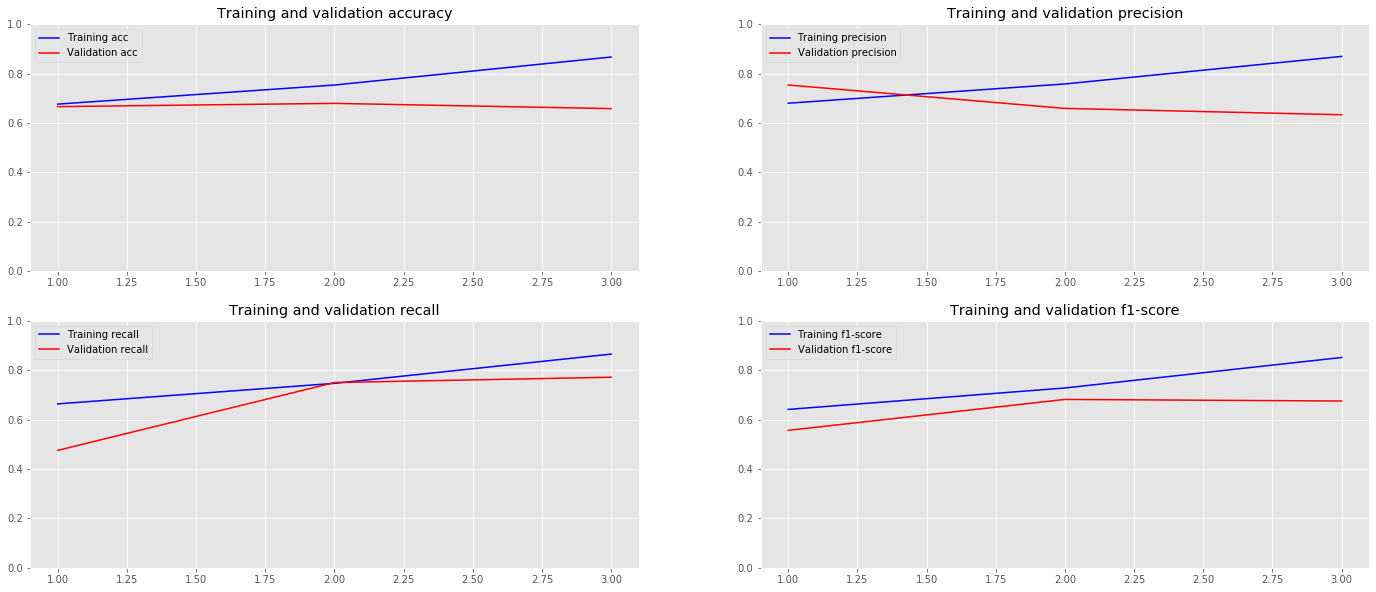

Wall time: 4min


In [37]:
%%time
print(datetime.datetime.now)
loss, accuracy, f1_score, precision, recall = model.evaluate(x_train, y_train, verbose=False)
# print("Training Accuracy: {:.4f}".format(accuracy))
print('Training Accuracy:', accuracy, '\nTraining Precision:', precision, '\nTraining Recall:', recall, '\nF1 Score:', f1_score)
loss, accuracy, f1_score, precision, recall = model.evaluate(x_test, y_test, verbose=False)
print('\nTesting Accuracy:', accuracy, '\nTesting Precision:', precision, '\nTesting Recall:', recall, '\nF1 Score:', f1_score)
plot_history(history)

## 3.- Analysis of the results
After applying the method with the best hyperparameters obtained after the Grid Search, we obtained a 0.68 F1-Score (Precision: 0.63 and Recall: 0.77). We only used 3 epochs in this case because more epochs would overfit the training set and return worse results (even with 3 epochs we can notice that the values of precision and accuracy are reduced in the last epoch). This result offers best results than majority class (0.5).